**Условие:**
Скачать набор данных creditcard.csv с https://www.kaggle.com/mlg-ulb/creditcardfraud, в котором: Time – время транзакции, V1-V28 – признаки, Amount – количество, Class – класс транзакции: мошенническая (Class=1) и легальная (Class=0).

Используйте из набора данных только первые 50 000 записей.

Используя train_test_split(…, test_size=0.3, stratify=df.Class) разбейте выборку (c_card.csv) на тренировочное и тестовое множества так, чтобы тестовая выборка составляла 30% от всей выборки и в тестовой выборке пропорция мошеннических и легальных транзакций была такой же как и в основной выборке (stratify).

При решении задачи классификации транзакций на мошеннические и легальные необходимо максимизировать метрику macro f1 на тестовой выборке.

Задания:

Задание 1 (3 балла максимум). Сравнить значения метрики macro_f1 при тестировании методов: дерево принятия решений, бэггинга деревьев решений и случайного леса.

Задание 2 (3 балла максимум). Оптимизировать/настроить параметры (GridSearchCV) случайного леса для максимизации значения f1_macro (scoring='f1_macro') на тестовой выборке. Для метода, обеспечившего максимум f1_macro, построить матрицу ошибок.

Задание 3 (4 балла максимум). Примененеие ансамблей моделей. Обучить и для обученных моделей получить (вывести на экран) матрицу метрик и матрицу ошибок на тестовой выборке, сравнить значение метрии f1_macro. Модели:

1. LightGBM-классификтор,

2. стекинг с не менее тремя моделями ML:

    1-я модель: Случайный лес с полученными в задаче 2 значениями,

    2-я модель: xgboost,
    
    3-я модель: выбрать самостоятельно.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

**Подготовка**

In [53]:
data = pd.read_csv("creditcard.csv", nrows=50000)        # Считываю первыые 50'000 записей из csv файла

In [54]:
x = data.drop(['Class', 'Time', 'Amount'], axis = 1)     # Входные параметры: Стоблики V1-V28
y = data['Class']                                        # Рузультаты (столбик Class, где 1 - мошенническая, 0 - легальная)

# Разделение выборки на тестовую (30%) и обучающую (100-30=70%),
# stratify=y: в тестовой выборке пропорция мошеннических и легальных транзакций была такой же как и в основной выборке
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

**Задание 1**

Сравнить значения метрики macro_f1 при тестировании методов: дерево принятия решений, бэггинга деревьев решений и случайного леса.

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

**1.1 Дерево приниятия решений**

Иерархия такой системы правил напоминают изображение перевернутого корнем вверх дерева, отсюда и название $-$ **дерево принятия решений**. Дерево включает в себя места разветвления $-$ **узлы**, корневую вершину (**корень**), **листья** и **ветки**. В узлах указаны признаки для принятия решения, значения признаков указаны на ветвях, в листьях указаны итоговые.

In [56]:
tree_classifier = DecisionTreeClassifier(random_state=42)   # Дерево принятия решений
tree_classifier.fit(x_train, y_train)                       # Обучаю дерево принятия решений

# average='macro' - нужно по заданию
tree_classifier_score = f1_score(y_test, tree_classifier.predict(x_test), average='macro')
print(tree_classifier_score)

0.8950479747368814


**1.2 Бэггинга деревьев решений**

Использует несколько методов или моделей в ML может обесепечить большее значние метрики исследования, чем при использовании одного метода.

In [57]:
bagging_classifier = BaggingClassifier(random_state=42)       # Бэггинг деревьев решений
bagging_classifier.fit(x_train, y_train)                      # Обучение

bagging_classifier_score = f1_score(y_test, bagging_classifier.predict(x_test), average='macro')
print(bagging_classifier_score)

0.9214694792137765


**1.3 Случайный лес**

**Случайный лес $-$ это беггинг деревьев. Использование бутсрэепа позволяет создавать разные деревья (обученные на разных подвыборках).**

Создать много неглубоких деревьев и применить голосование "по большинству". Если 90% деревьев выбрали один и тот же класс, то можно поверить "большинству". Много случайно созданных деревьев образуют **случайный лес**.


In [58]:
random_forest_classifier = RandomForestClassifier(random_state=42)       # Случайный лес
random_forest_classifier.fit(x_train, y_train)                           # Обучение

random_forest_classifier_score = f1_score(y_test, random_forest_classifier.predict(x_test), average='macro')
print(random_forest_classifier_score)

0.9522472446660173


**Задание 2**

Оптимизировать/настроить параметры (GridSearchCV) случайного леса для максимизации значения f1_macro (scoring='f1_macro') на тестовой выборке. Для метода, обеспечившего максимум f1_macro, построить матрицу ошибок.

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt  # Средство визуализации данных и построения графиков

In [60]:
def get_metrics_plot_confusion_matrix(clf, y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)  # Матрица ошибок

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)     # Отображение матрицы ошибок
  disp.plot()
  plt.show()

In [61]:
# Определение параметров для GridSearchCV
param_grid = {
    'n_estimators': [10, 20, 30],               # Количество деревьев в случайном лесу. Пробую значения 10, 20, 30
    'max_depth': [None, 10, 20],                # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],            # Минимальное количество образцов, необходимое для разделения узла.
    'min_samples_leaf': [1, 2, 4],              # Минимальное количество образцов, необходимое для листа
} 

grid_search = GridSearchCV(estimator=random_forest_classifier, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=4)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 20, 30]},
             scoring='f1_macro')

In [62]:
# best_estimator_: Лучшая модель
grid_search_best = grid_search.best_estimator_
y_pred = grid_search_best.predict(x_test)

# Оценка на тестовой выборке
f1_macro = f1_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)

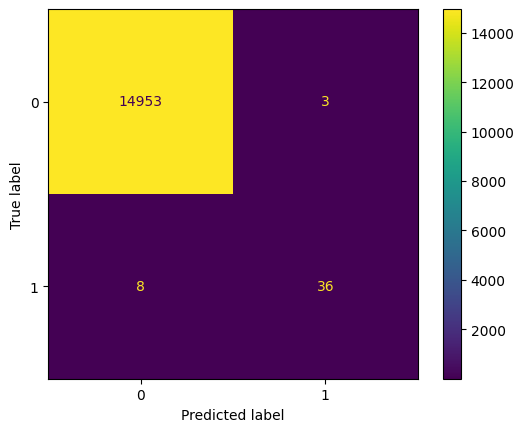

Лучшие параметры: RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=20, random_state=42)
f1-macro на тестовой выборке: 0.9335510977962724


In [63]:
get_metrics_plot_confusion_matrix(grid_search, y_test, y_pred)

print("Лучшие параметры:", grid_search_best)
print("f1-macro на тестовой выборке:", f1_macro)

**Задание 3**

Примененеие ансамблей моделей. Обучить и для обученных моделей получить (вывести на экран) матрицу метрик и матрицу ошибок на тестовой выборке, сравнить значение метрии f1_macro. Модели:

1. LightGBM-классификтор,

2. стекинг с не менее тремя моделями ML:

    1-я модель: Случайный лес с полученными в задаче 2 значениями,

    2-я модель: xgboost,
    
    3-я модель: выбрать самостоятельно.

In [64]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier

**3.1 Модель LightGBM-классификатор**

[LightGBM] [Info] Number of positive: 104, number of negative: 34896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002971 -> initscore=-5.815737
[LightGBM] [Info] Start training from score -5.815737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

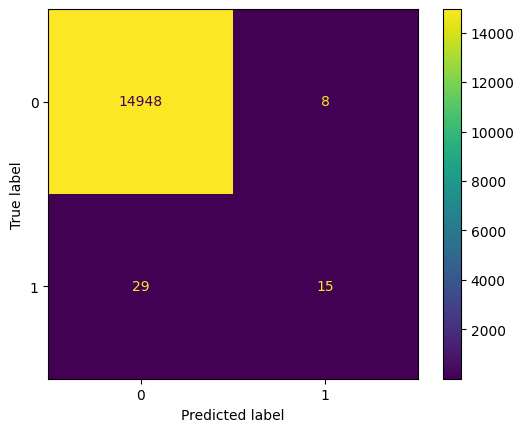

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14956
           1       0.65      0.34      0.45        44

    accuracy                           1.00     15000
   macro avg       0.83      0.67      0.72     15000
weighted avg       1.00      1.00      1.00     15000



In [65]:
lgbm = LGBMClassifier(random_state=42)                 # LightGBM-классификтор
lgbm.fit(x_train, y_train)
y_pred = lgbm.predict(x_test)
lgbm_f1_macro = f1_score(y_test, y_pred, average='macro')

get_metrics_plot_confusion_matrix(lgbm, y_test, y_pred)
print(classification_report(y_test, y_pred))


**3.2 Стекинг с не менее тремя моделями ML**

Learning rate set to 0.047017
0:	learn: 0.5310583	total: 12.5ms	remaining: 12.5s
1:	learn: 0.4098765	total: 24.4ms	remaining: 12.2s
2:	learn: 0.3139580	total: 34.8ms	remaining: 11.6s
3:	learn: 0.2387772	total: 45.1ms	remaining: 11.2s
4:	learn: 0.1822652	total: 56.6ms	remaining: 11.3s
5:	learn: 0.1404565	total: 67ms	remaining: 11.1s
6:	learn: 0.1108755	total: 77.4ms	remaining: 11s
7:	learn: 0.0854825	total: 87.7ms	remaining: 10.9s
8:	learn: 0.0681535	total: 98.2ms	remaining: 10.8s
9:	learn: 0.0554926	total: 109ms	remaining: 10.8s
10:	learn: 0.0451895	total: 119ms	remaining: 10.7s
11:	learn: 0.0369333	total: 130ms	remaining: 10.7s
12:	learn: 0.0301254	total: 140ms	remaining: 10.6s
13:	learn: 0.0248857	total: 151ms	remaining: 10.6s
14:	learn: 0.0205457	total: 161ms	remaining: 10.6s
15:	learn: 0.0172615	total: 171ms	remaining: 10.5s
16:	learn: 0.0147165	total: 181ms	remaining: 10.5s
17:	learn: 0.0128637	total: 191ms	remaining: 10.4s
18:	learn: 0.0112134	total: 201ms	remaining: 10.4s
19:	le

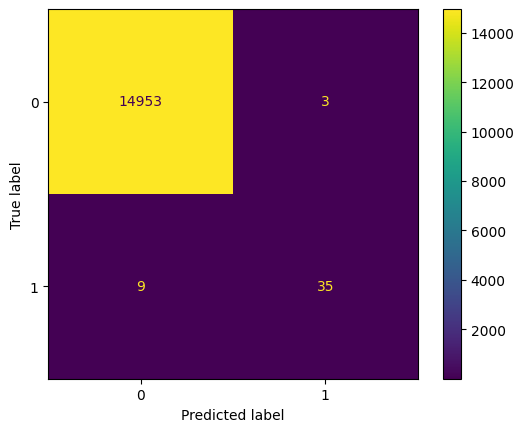

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14956
           1       0.92      0.80      0.85        44

    accuracy                           1.00     15000
   macro avg       0.96      0.90      0.93     15000
weighted avg       1.00      1.00      1.00     15000



In [ ]:
# Стекинг моделей
estimators = [
    ('rf', grid_search_best),   # Случайный лес с полученными в задаче 2 значениями
    ('xgb', XGBClassifier(random_state=42)),                   # Градиентный бустинг XGB
    ('cb', CatBoostClassifier(random_state=42))                # Catboost (categorical boosting) для градиентного бустинга деревьев
]

clf = StackingClassifier(estimators=estimators)
clf.fit(x_train, y_train)               # Обучение
y_pred = clf.predict(x_test)            # Предсказание классов тестовых данных

get_metrics_plot_confusion_matrix(clf, y_test, y_pred)
print(classification_report(y_test, y_pred))